In [1]:
import os, sys
sys.path.insert(0, os.path.abspath(os.path.join("..", "..")))

# With real data

Using the model with KDE estimates for background and trigger, but with the trigger split between space and time.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sepp.sepp_full
import open_cp.logger
open_cp.logger.log_to_true_stdout("sepp")
open_cp.logger.log_to_true_stdout()
import open_cp.sources.chicago
import open_cp.geometry
import descartes
import pickle, lzma, datetime, collections, os
import open_cp.predictors
import sepp.kernels
import scipy.stats

In [3]:
datadir = os.path.join("..", "..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
open_cp.sources.chicago.set_data_directory(datadir)

with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as file:
    all_points = open_cp.sources.chicago.load(file, "BURGLARY", type="all")

In [4]:
northside = open_cp.sources.chicago.get_side("North")
grid = open_cp.data.Grid(150, 150, 0, 0)
grid = open_cp.geometry.mask_grid_by_intersection(northside, grid)

In [5]:
mask = (all_points.timestamps >= np.datetime64("2016-01-01")) & (all_points.timestamps < np.datetime64("2017-01-01"))
points = all_points[mask]
points = open_cp.geometry.intersect_timed_points(points, northside)

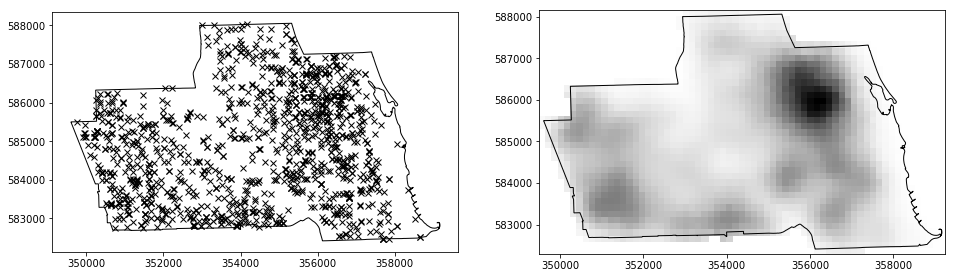

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(16,10))

ax = axes[0]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.scatter(points.xcoords, points.ycoords, marker="x", color="black", linewidth=1)

kernel = open_cp.kernels.GaussianBase(points.coords)
kernel.bandwidth = 300
kernel.covariance_matrix = [[1,0], [0,1]]
_pred = open_cp.predictors.grid_prediction_from_kernel_and_masked_grid(kernel, grid, samples=5)
ax = axes[1]
ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
ax.set_aspect(1)
ax.pcolor(*_pred.mesh_data(), _pred.intensity_matrix, cmap="Greys", rasterized=True)
None

## Plotting functions

In [7]:
def compute_plot_kde(ker, size):
    x = np.linspace(-size, size, 151)
    y = x
    xcs, ycs = np.meshgrid(x, y)
    z = ker([xcs.flatten(), ycs.flatten()])
    z = z.reshape(xcs.shape)
    return x, y, z

def plot_kde(ax, ker, size, postprocess=None):
    x, y, z = compute_plot_kde(ker, size)
    if postprocess is not None:
        z = postprocess(z)
    return ax.pcolormesh(x,y,z, cmap="Greys", rasterized=True)

def backup_limits(ax):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    return xmin, xmax, ymin, ymax

def set_limits(ax, xmin, xmax, ymin, ymax):
    ax.set(xlim=(xmin, xmax), ylim=(ymin, ymax))
    
def plot(model, space_size=35, time_size=100, space_floor=None):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    ax = axes[0]
    ax.add_patch(descartes.PolygonPatch(northside, fc="none"))
    ax.set_aspect(1)
    bpred = open_cp.predictors.grid_prediction_from_kernel(model.background_kernel, grid.region(), grid.xsize)
    #bpred = open_cp.predictors.GridPredictionArray(grid.xsize, grid.ysize, model.mu, grid.xoffset, grid.yoffset)
    m = ax.pcolor(*bpred.mesh_data(), bpred.intensity_matrix, cmap="Greys", rasterized=True)
    cb = fig.colorbar(m, ax=ax)

    ax = axes[1]
    x = np.linspace(0, time_size, 200)
    y = model.theta * model.trigger_time_kernel(x)
    ax.plot(x, y, color="black")
    ax.set(xlabel="Days", ylabel="Trigger risk")
    y = np.max(y)
    for t in range(0, time_size+1):
        ax.plot([t,t],[0,y], color="grey", linewidth=0.5, linestyle="--", zorder=-10)

    pp = None
    if space_floor is not None:
        pp = lambda z : np.log(space_floor + z)
    m = plot_kde(axes[2], model.trigger_space_kernel, space_size, pp)
    plt.colorbar(m, ax=axes[2])
        
    fig.tight_layout()
    return fig

def plot_scatter_triggers(backgrounds, trigger_deltas):
    fig, axes = plt.subplots(ncols=3, figsize=(16,5))

    def add_kde(ax, pts):
        xmin, xmax, ymin, ymax = backup_limits(ax)
        x = np.linspace(xmin, xmax, 151)
        y = np.linspace(ymin, ymax, 151)
        xcs, ycs = np.meshgrid(x, y)
        ker = scipy.stats.kde.gaussian_kde(pts)
        z = ker([xcs.flatten(), ycs.flatten()])
        z = z.reshape(xcs.shape)
        z = np.log(np.exp(-15)+z)
        m = ax.pcolorfast(x,y,z, cmap="Greys", rasterized=True, alpha=0.7, zorder=-10)

    ax = axes[0]
    pts = trigger_deltas[1:]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set_title("Space trigger points")

    ax = axes[1]
    pts = trigger_deltas[[0,1]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="x coord")#, xlim=[0,200])

    ax = axes[2]
    pts = trigger_deltas[[0,2]]
    ax.scatter(*pts, marker="x", color="black", linewidth=1)
    add_kde(ax, pts)
    ax.set(xlabel="days", ylabel="y coord")

    fig.tight_layout()
    return fig

def scatter_triggers(trainer, model, predict_time):
    backgrounds, trigger_deltas = trainer.sample_to_points(model, predict_time)
    return plot_scatter_triggers(backgrounds, trigger_deltas), backgrounds, trigger_deltas

## Fixed bandwidth

In [8]:
tk_time_prov = sepp.kernels.FixedBandwidthKernelProvider(1)
tk_space_prov = sepp.kernels.FixedBandwidthKernelProvider(20, cutoff=750)
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(100)
opt_fac = sepp.sepp_full.Optimiser1Factory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2017,1,1))
model = trainer.train(datetime.datetime(2017,1,1), iterations=50)
model

Model1(T=365.9583333333333, mu=2.35751613245522, background=<open_cp.kernels.GaussianBase object at 0x00000202A3E73898>, theta=0.29800433308400476, trigger=<open_cp.kernels.Reflect1D object at 0x000002029E5EB0B8>,<open_cp.kernels.GaussianBase object at 0x000002029E5E6E48>

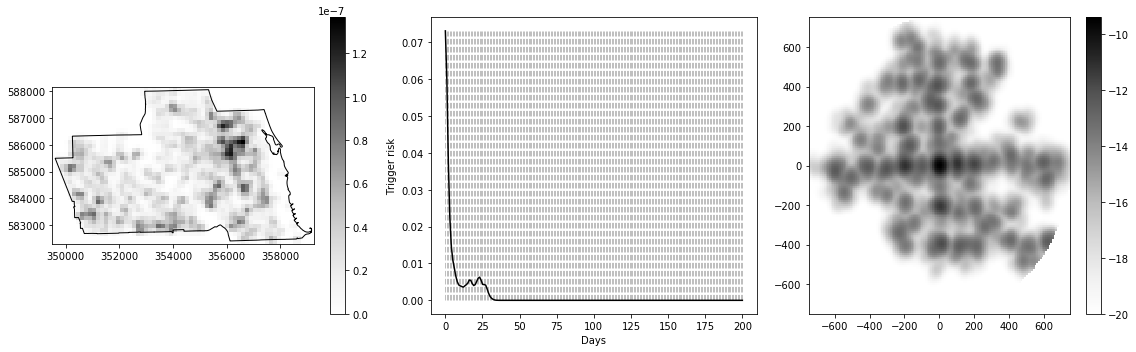

In [9]:
fig = plot(model, space_size=750, time_size=200, space_floor=np.exp(-20))

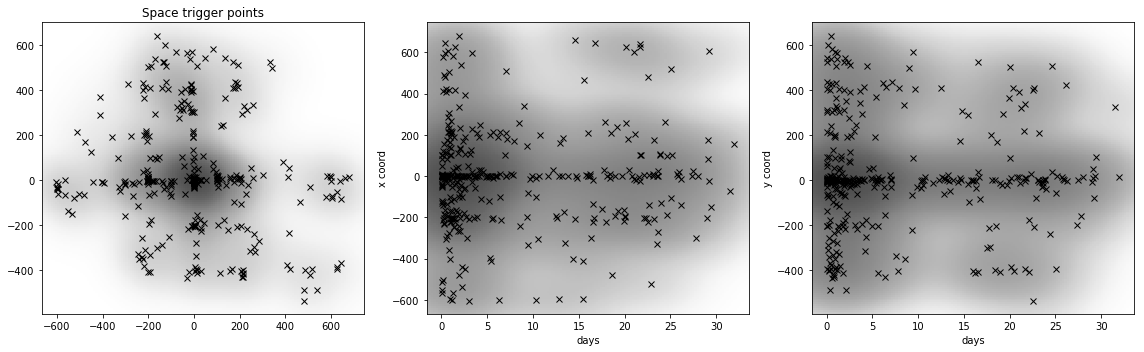

In [10]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

In [11]:
for _ in range(30):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

Model1(T=365.9583333333333, mu=2.340220863955525, background=<open_cp.kernels.GaussianBase object at 0x000002029F5A0080>, theta=0.3031543311594325, trigger=<open_cp.kernels.Reflect1D object at 0x000002029FA92668>,<open_cp.kernels.GaussianBase object at 0x000002029FA71C88>

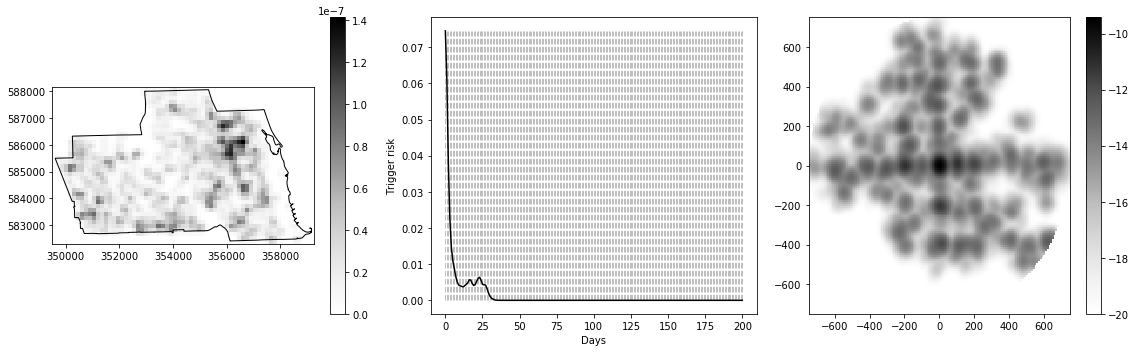

In [12]:
fig = plot(model, space_size=750, time_size=200, space_floor=np.exp(-20))

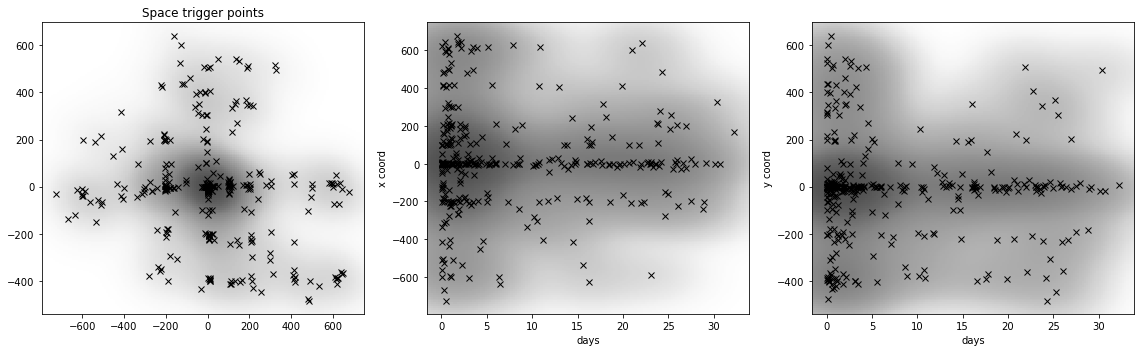

In [13]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

In [14]:
for _ in range(30):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

Model1(T=365.9583333333333, mu=2.333852803528482, background=<open_cp.kernels.GaussianBase object at 0x00000202A47D3CC0>, theta=0.3050505433485675, trigger=<open_cp.kernels.Reflect1D object at 0x000002029EE013C8>,<open_cp.kernels.GaussianBase object at 0x000002029EE01A90>

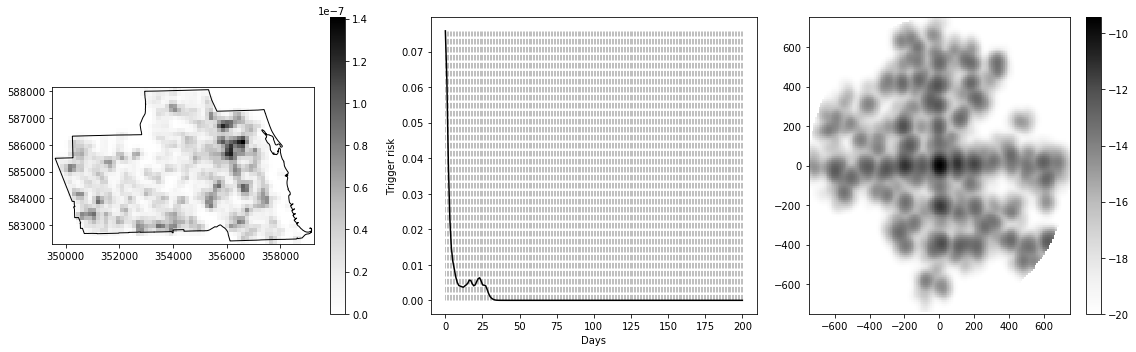

In [15]:
fig = plot(model, space_size=750, time_size=200, space_floor=np.exp(-20))

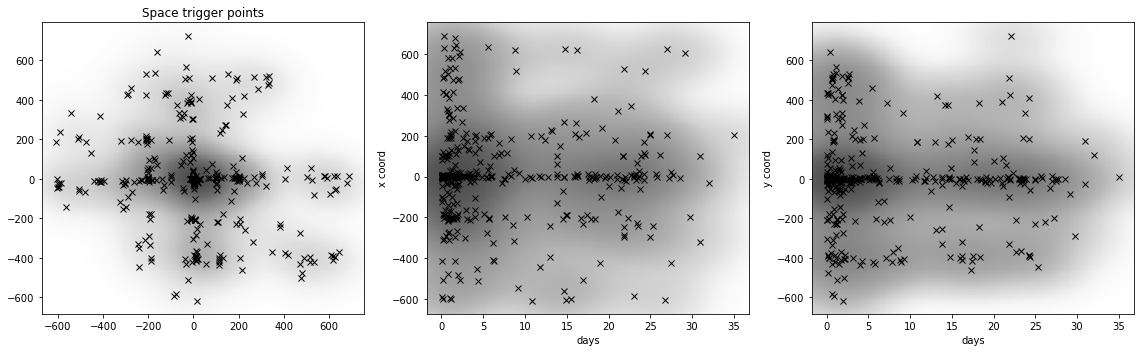

In [16]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

## Stochastic EM

In [8]:
tk_time_prov = sepp.kernels.FixedBandwidthKernelProvider(1)
tk_space_prov = sepp.kernels.FixedBandwidthKernelProvider(20, cutoff=1000)
back_ker_prov = sepp.kernels.FixedBandwidthKernelProvider(100)
opt_fac = sepp.sepp_full.Optimiser1SEMFactory(back_ker_prov, tk_time_prov, tk_space_prov)
trainer = sepp.sepp_full.Trainer1(opt_fac)
trainer.data = points
T, data = trainer.make_data(datetime.datetime(2018,1,1))
model = trainer.train(datetime.datetime(2018,1,1), iterations=25)
model

Model1(T=730.9583333333334, mu=0.822946393541407, background=<open_cp.kernels.GaussianBase object at 0x000001E3C7CD4128>, theta=0.5105455457724136, trigger=<open_cp.kernels.Reflect1D object at 0x000001E3C7BE96D8>,<open_cp.kernels.GaussianBase object at 0x000001E3C7C6CD68>

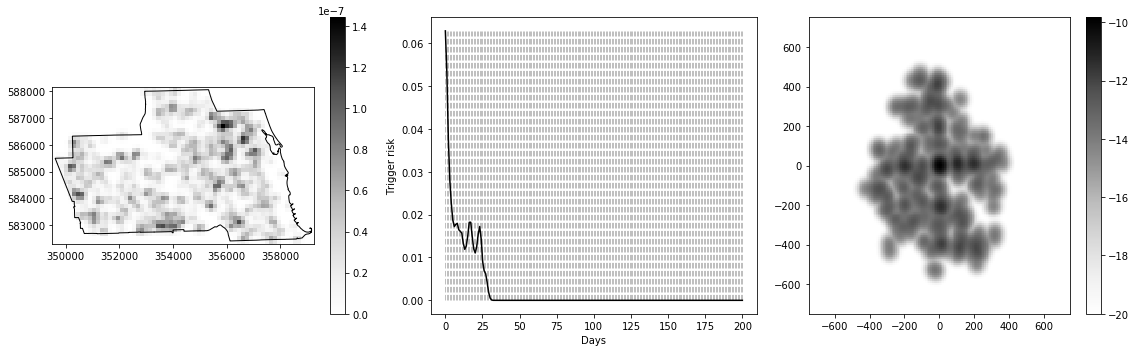

In [9]:
fig = plot(model, space_size=750, time_size=200, space_floor=np.exp(-20))

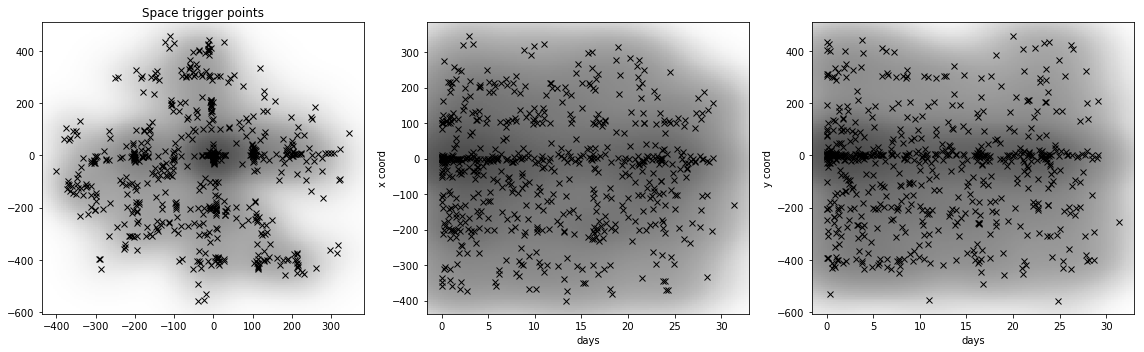

In [10]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

In [11]:
for _ in range(50):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

Model1(T=730.9583333333334, mu=0.2351393373601388, background=<open_cp.kernels.GaussianBase object at 0x000001E3CBF375F8>, theta=0.8601488542409499, trigger=<open_cp.kernels.Reflect1D object at 0x000001E3CBA84668>,<open_cp.kernels.GaussianBase object at 0x000001E3CBF0B630>

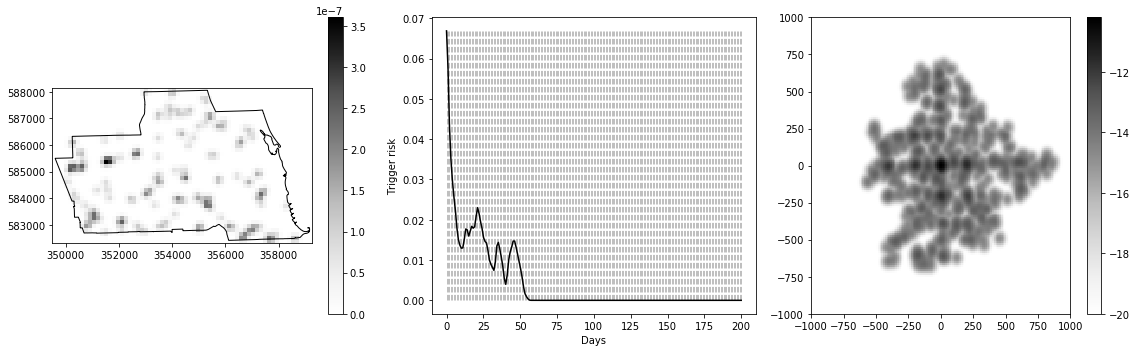

In [12]:
fig = plot(model, space_size=1000, time_size=200, space_floor=np.exp(-20))

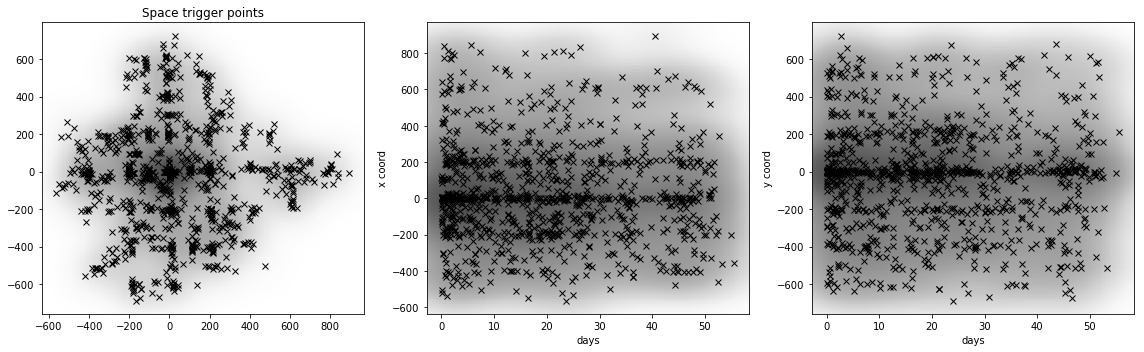

In [13]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))

In [14]:
for _ in range(50):
    opt = trainer._optimiser(model, data)
    model = opt.iterate()
model

Model1(T=730.9583333333334, mu=0.13728917886494996, background=<open_cp.kernels.GaussianBase object at 0x000001E3CB4B1198>, theta=0.9183460786266675, trigger=<open_cp.kernels.Reflect1D object at 0x000001E3CA6BB630>,<open_cp.kernels.GaussianBase object at 0x000001E3CA6BBE10>

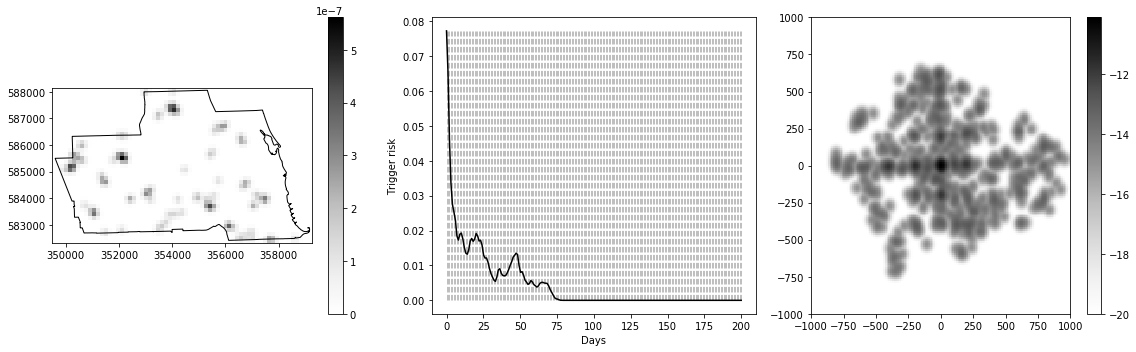

In [15]:
fig = plot(model, space_size=1000, time_size=200, space_floor=np.exp(-20))

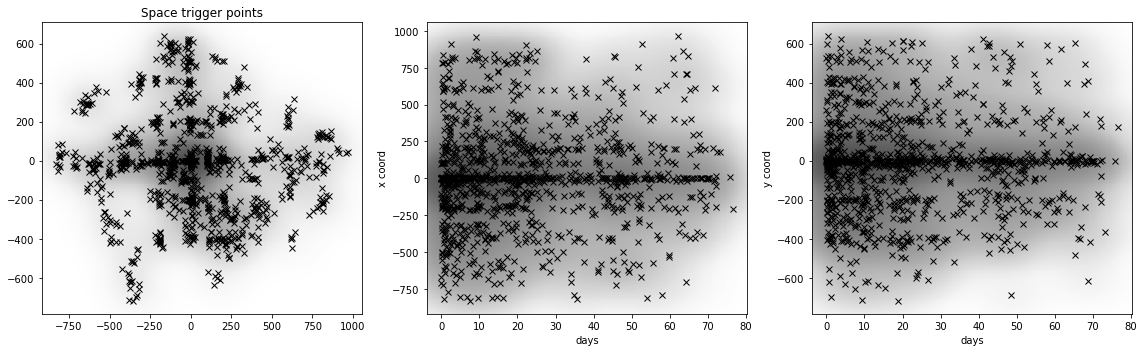

In [16]:
fig, *_ = scatter_triggers(trainer, model, datetime.datetime(2017,1,1))